# 7 - Accelerating quantum processes

Last time, we saw hints of being able to accelerate quantum processes like spontaneous emission and excitation transfer by "delocalising" excitations across many TLS. 

In this tutorial, we'll see just how much speedup we can get by developing a description of many TLS (called "Dicke states") that allows us to set up delocalised excitations easily and also helps us avoid getting stuck in a computational bottleneck. 



In [7]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals

from scipy.stats import linregress
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

# The helper file below brings functions created in previous tutorials
from libs.helper_07_tutorial import *

## 7.1 -  Recap

So far, we've described a combined TLS + quantum field using a notation like, e.g. $|0,+,-,-,- \rangle$. The first number (in this case $0$) tells us the number of bosons present (this is often referred to as a [Fock state](https://en.wikipedia.org/wiki/Fock_state)), and the $\pm$ tell us what state each of the $N$ TLS are in ($+$ excited, $-$ ground). This is a complete description in the sense that every configuration of the system can be described as a mixture of these states. For example, a single excitation delocalised across 4 TLS with no bosons can be described by:

$\Psi_0 \sim | 0, +, -, -, - \rangle + | 0, -, +, -, - \rangle + | 0, -, -, +, - \rangle + | 0, -, -, -, + \rangle $


The issue with this description is that, for a specific number of bosons, there are $2^N$ possibilities for the state of the TLS and that means it becomes infeasible to simulate more than about 10 TLS.

Because delocalised excitations are of most interest to us today, we don't actually need a lot of the detail that the complete description holds. Superficially, we'd be quite happy with a simpler description like $| n, n_+ \rangle$ - where $n$ is the boson number and $n_+$ is the number of excitations. There would only be $N+1$  possibilities for the state of the TLS in this case - this is much more favourable from a computational perspective. 

Let's see if we can make this simpler description rigorous enough to help us with simulating many TLS.

## 7.2 - Angular momentum $J$ 

Creating a description of delocalised excitations is not quite as simple as $| n, n_+ \rangle$. For example, the following delocalised states contain the same number of delocalised excitations but they're different:

$\Psi_1 \sim | 0, +, - \rangle + | 0, -, + \rangle $

In [2]:
psi_1 = basis([2,2], [0,1]) + basis([2,2], [1,0])
psi_1 = psi_1.unit()
psi_1

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]]

$\Psi_2 \sim | 0, +, - \rangle - | 0, -, + \rangle $

In [3]:
psi_2 = basis([2,2], [0,1]) - basis([2,2], [1,0])
psi_2 = psi_2.unit()
psi_2

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.70710678]
 [-0.70710678]
 [ 0.        ]]

What makes these states physically different is related to what we normally think of as their angular momentum. We're therefore going to need to add some angular momentum information to our states. 

Ultimately, our states are going to need to look like:

$\Psi \sim | n, j, m \rangle$

Where:
- $n$ - boson number = $0,1,2,3,...$
- $j$ - [total angular momentum quantum number](https://en.wikipedia.org/wiki/Total_angular_momentum_quantum_number) = $0,\frac{1}{2},1,\frac{3}{2},2,\frac{5}{2}, 3, ...$
- $m$ - [magnetic quantum number](https://en.wikipedia.org/wiki/Magnetic_quantum_number) = $j, (j-1), (j-2), ..., -(j-2), -(j-1), -j$

It's not obvious where all those numbers come from and how they can be mapped to e.g. 4 TLS with a single delocalised excitation? So, let's figure that out.

### Angular momentum numbers

Although we don't explicitly have a description of angular momentum in our TLS, you may recall from tutorial 2 that our system is mathematically equivalent to spin 1/2 particles which do have angular momentum. We can also see this explicitly in the language we've been using to describe our Hamiltonian:

$$H =  \Delta E J_{Nz} + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)2J_{Nx}$$

In [9]:
H_latex = "$H = \Delta E J_{Nz} + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2J_{Nx}$ "

where:

- The [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) ($J$) for $N$ TLS:

$$J_{Nx} = \overset{N}{\underset{n=1}{\Sigma}} S_{n x} \,\,\,\,\,\, J_{Ny} = \overset{N}{\underset{n=1}{\Sigma}} S_{n y} \,\,\,\,\,\, J_{Nz} = \overset{N}{\underset{n=1}{\Sigma}} S_{n z}$$

- The spin operators ($S$) for a [spin 1/2 particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables):

$$
S_x = \frac{1}{2}\sigma_x \,\,\,\,\,\, S_y = \frac{1}{2}\sigma_y \,\,\,\,\,\, S_z = \frac{1}{2}\sigma_z
$$

We'll continue to talk about angular momentum here to keep as sense of familiarity. Eventually we'll move to a more abstract way of thinking about $J$, but that can wait.

So far, we've seen that the x and z "components" of the total angular momentum operator $J_x$ and $J_z$ are used in the Hamiltonian. I use quote marks around "component" because this is vector language which is not obviously applicable to operators. It turns out, however, that we can (in some sense) treat the angular momentum operator as a vector (see [spinors](https://en.wikipedia.org/wiki/Spinors_in_three_dimensions)). We can create the squared "magnitude" of the total angular momentum operator ($J^2$) much like we would a vector by summing of the squares of the components.

Let's see this for the case of 2 TLS.

In [5]:
Jx, Jy, Jz = jspin(2, basis="uncoupled")
J2 = Jx*Jx + Jy*Jy + Jz*Jz

What does this operator tell us about how we might go about differentiating between states like $\Psi_1$ and $\Psi_2$ that have the same amount of delocalised excitation?

If $\Psi_1$ and $\Psi_2$ are eigenstates of $J^2$ (i.e. $J^2 \Psi = \lambda \Psi$) then those states have specific, well defined, angular momentum that's characterised by the constant (eigenvalue) $\lambda$. That constant could then be used to label our states.

In [6]:
J2*psi_1

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.        ]
 [1.41421356]
 [1.41421356]
 [0.        ]]

In [7]:
J2*psi_2

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]]

We can therefore see that:
- $J^2 \Psi_1 = 2 \Psi_1 \implies$  $\lambda = 2$
- $J^2 \Psi_2 = 0 \Psi_2 \implies$ $\lambda = 0$

Although not immediately obvious, these eigenvalues of $J^2$ [always have the form $j(j+1)$](https://www.feynmanlectures.caltech.edu/II_34.html#Ch34-S7), where $j$ is either an integer or half integer. 

In [8]:
evalsJ, eketsJ = J2.eigenstates()

In [9]:
evalsJ

array([0., 2., 2., 2.])

Without explicitly looking at all the eigenstates of $J^2$, we know there must be:
- 1 state with $j=0$ (we've seen that already with $\Psi_1$)
- 3 states with $j=1$ (we've seen one of those with $\Psi_2$)

You might wonder how we're able to have 3 states with the same angular momentum number $j$? They have different $J_z$ - what is known as the "magnetic quantum number" often given the label $m$. 

In quantum mechanics, it has been found experimentally that [angular momentum is quantised](https://www.feynmanlectures.caltech.edu/II_34.html#Ch34-S7) in the sense that when its z component is measured it can only take values $m\hbar$ where $m = j, (j-1), (j-2), ..., -(j-2), -(j-1), -j$. We can see this explicitly by looking at the eigenvalues of $J_z$.

In [10]:
evalsM, eketsM = Jz.eigenstates()

In [11]:
evalsM

array([-1.,  0.,  0.,  1.])

For $N=2$, the TLS can therefore be described in terms of angular momentum by giving 2 numbers $|j,m\rangle$:
- $| 0, 0 \rangle$ - this is $\Psi_1$
- $|1, -1 \rangle$
- $|1, 0 \rangle$ - this is $\Psi_2$
- $|1, 1\rangle$

This is actually a complete description because for 2 TLS there are only 4 states, $| -, - \rangle$, $| +, - \rangle$, $| -, + \rangle$, $| +, + \rangle$. This is not the case for $N>2$.  In general, we lose the ability to describe every state uniquely when we use this angular momentum description. In other words, there can be many states with the same $j,m$ values (degenerate states). When you enumerate all the states in the angular momentum description, there are $\sim N^2$ possibilities compared to the $2^N$ we've been working with up to now. This is ultimately what's going to give us a computational advantage but we do need to be a bit careful as to whether we lose any physics when we do this. 
> Advanced: Use [`state_degeneracy(N,j)`](https://qutip.org/docs/4.4/apidoc/functions.html?highlight=m_degeneracy#qutip.piqs.state_degeneracy) to calculate the degeneracy of each state. In general there are some subtleties to consider when ignoring degeneracy which might need to be considered depending on the problem at hand (see last paragraph of [Permutational Invariant Quantum Solver](http://qutip.org/docs/latest/guide/dynamics/dynamics-piqs.html)). For now, we don't need to worry about this so we will put a pin in this advanced topic and return to it in a later tutorial.


Hopefully you've got a better understanding of these angular momentum numbers. Now we need to link it back to the number of TLS $N$ and the number of delocalised excitations $n_+$.

### Dicke states

Consider 4 TLS with a single delocalised excitation, how can we write this in our new angular momentum description with $j,m$?

$m$ is actually very closely related to the number of excitations $n_{+}$, it's:

$$m= \frac{1}{2}\left(n_{+} - n_{-} \right) = \frac{1}{2}\left(n_{+} - (N - n_{+}) \right) = n_+ - N/2$$

For 4 TLS with a single delocalised excitation, we'd have $m = 1 - \frac{4}{2} = -1$. What about $j$?

As we saw earlier, there are several $j$'s for a given $m$. In general, the specific $j$, $m$ combinations come from adding up the angular momentum for many single TLS (with $j=1/2$) like vectors of the same length but different (quantised) orientations. The details are somewhat tedious - often involving [formidable lookup tables](http://pdg.lbl.gov/2019/reviews/rpp2019-rev-clebsch-gordan-coefs.pdf). Luckily for us, QuTiP, has some convenient functions (that are somewhat hidden inside of [`qutip.cy.piqs`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx)) to help us.
- [`j_vals(N)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L130) - tells us the different $j$ values for $N$ TLS.
- [`m_vals(j)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L147) tells us the $m$ values for a given $j$





In [12]:
j_vals(4) # Gives the different j's for 4 TLS

array([0., 1., 2.])

In [13]:
m_vals(2) # Gives us m values for j=2

array([-2, -1,  0,  1,  2])

In [14]:
m_vals(1) # Gives us m values for j=1

array([-1,  0,  1])

In [15]:
m_vals(0) # Gives us m values for j=0

array([0])

We can see that there is an $m=-1$ for $j=2$ and $j=1$. Which one should we pick?

By far the most significant $j$ is the largest $j_{\max} = N/2$. The largest $j$ corresponds to what's called a `Dicke state`. 

A Dicke state is a symmetric state, which means if you swap any of the TLS around, the state remains unchanged. For example, consider a single excitation in 4 TLS. The Dicke state looks like:

$\Psi_0 = \frac{1}{\sqrt{4}}\left(| 0, +, -, -, - \rangle + | 0, -, +, -, - \rangle + | 0, -, -, +, - \rangle + | 0, -, -, -, + \rangle \right)$

Notice that if you swap any two TLS, the state looks the same.

The reason why $j_{\max}$ is most significant is because of the acceleration properties that these Dicke states offer; something people often describe as superradiance and supertransfer. We're going to see this in action in the next section.

Before we get there, we need to take a short detour into angular momentum conservation.

### Conservation of angular momentum

Angular momentum is conserved in our model and so we have a choice which $j$ value we want to run our simulation with. Once we set the system up with this $j$ it will keep that same $j$. This gives us an additional computational advantage above what we've already got from using the angular momentum description.

Instead of needing to keep track of the $N^2$ different angular momentum states, we only need to keep track of the $2j+1$ different $m$ states that correspond to the $j$ we picked. The worst case scenario is the Dicke states which use $j_{\max} = N/2$. For simulating Dicke states we need to keep track of $N+1$ states. This is an incredible improvement - going from an exponential scaling with number of TLS to linear.

You might think it would be a pain to extract only the states that correspond to a particular $j$, but once again QuTiP has got our back  with [`jmat(j)`](https://qutip.org/docs/latest/apidoc/functions.html?highlight=jmat#qutip.operators.jmat) - it does 2 things:
- Automatically gives us operators in the angular momentum basis, i.e. $|j,m \rangle$
- Returns only parts of the operators that act on the $j$ we pick

Let's look at an example:

In [16]:
N = 2 # 2 TLS
Jx, Jy, Jz = jmat(N/2) # j=j_max = N/2 means only Dicke states allowed
Jz

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -1.]]

We've got a 3x3 matrix because there are only 3 states corresponding to $m=1,0,-1$ for $j=1$. The matrix also signposts to us QuTip's convention for labeling the angular momentum states.


$$
|1,1> = \begin{bmatrix}
 1   \\
 0   \\
 0   \\
 \end{bmatrix}, 
|1,0> = \begin{bmatrix}
 0   \\
 1   \\
0   \\
\end{bmatrix}, 
|1,-1> = \begin{bmatrix}
 0   \\
 0   \\
1   \\
\end{bmatrix}
$$

Largest $m$ at the top of the state vector, smallest $m$ at the bottom.

Ok, we're ready to explore the suped up version of quantum mechanics.

## 7.3 Superradiance

Let's reconsider the case of spontaneous emission. We saw in tutorial 3 that such emission from a TLS can be understood as the result of coupling to a quantised field. The stronger the coupling, the faster the emission as seen by the increased Rabi frequency.

For emission from many TLS, we'd expect the rate to depend on the number of TLS that are excited. We might argue, for example, that the rate of emission is simply the sum of the rates of the individual TLS. In other words, we'd expect a factor of $N$ speedup for $N$ TLS that are excited.

Let's simulate it and check.

First, we're going to need modify our `make_operators` function from the last tutorial slightly. We'll be using `j = jmax` (i.e. we'll start with a Dicke state) and we'll also enumerate the states in `nm_list` in terms of number of TLS that are excited $n_+$ instead of using $m$. We can do this because:

$$m = n_+ - N/2$$

Since $m = j, j-1,...-j$ and $N/2 = j$ for Dicke states, then $$n_+ = m+j = 2j, 2j-1, 2j-2, ..., 3,2,1,0$$



In [4]:
def make_operators(max_bosons=2, parity=0, num_TLS=1):

    jmax = num_TLS/2              # max j gives us Dicke states
    
    J     = jmat(jmax)
    Jx    = tensor(qeye(max_bosons+1), J[0])                                     # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                                     # tensorised Jx operator
    a     = tensor(destroy(max_bosons+1), qeye(J[0].dims[0][0]))                 # tensorised boson destruction operator

    two_state     = Jz                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction   = 2*(a.dag() + a) * Jx                # interaction energy operator        2(𝑎†+𝑎)Jx  
    
    P = (1j*np.pi*(number + Jz + num_TLS/2)).expm()    # parity operator 
    
    # map from QuTiP number states to |n,m> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = range(int(2*jmax), -1, -1)
    nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]

    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
    else:
        p               = np.where(P.diag()==P.diag())[0]
        
    two_state       = two_state.extract_states(p)
    bosons          = bosons.extract_states(p)
    number          = number.extract_states(p)
    interaction     = interaction.extract_states(p)
    nm_list        = [nm_list[i] for i in p]
  
    return two_state, bosons, interaction, number, nm_list

Next we'll need to initialise the system with $N$ excitations. We do this via `psi0_ind = nm_list.index((0,N))`  - field in vacuum state (0) with $N$ excitations (N).

We're also going to need to change how we measure emission time. Previously we relied on the Rabi cycle and searched for the peaks in oscillations of the expectation number of bosons. Now, because we've got the potential to have $N$ bosons, we're going to need to search for times when the expected number of bosons reaches 1. We can then define a frequency associated with this time just as we did with Rabi frequency.

To retain good accuracy in finding when the first boson is emitted, we're going to dynamically shorten our simulations.

Finally, we're going to reduce the coupling constant by a factor of 10 compared to the last tutorial because we're now going to try simulating 100+ TLS 💪. The more TLS we have and the larger number of bosons present, the less of a perturbation the field becomes. If we want to stay in a perturbative regime, then $U$ need to be reduced accordingly.

In [347]:
DeltaE = 1
omega = 1
U = 0.001 # Note this is a factor of 10 lower than in the last tutorial

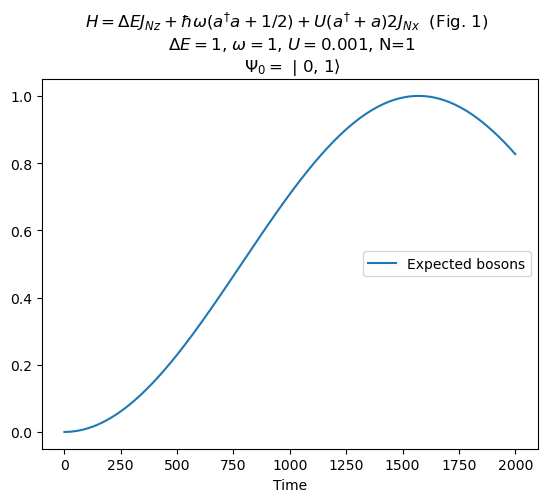

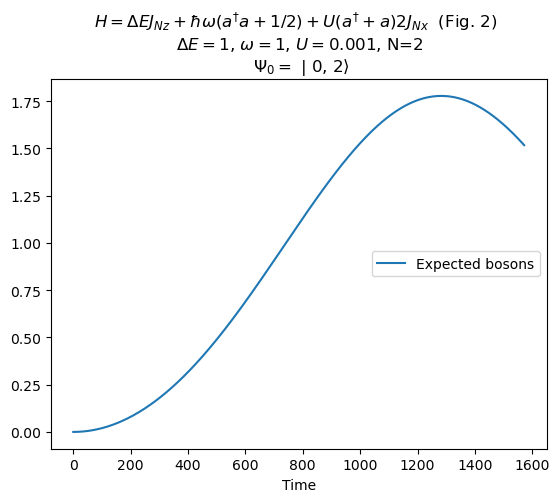

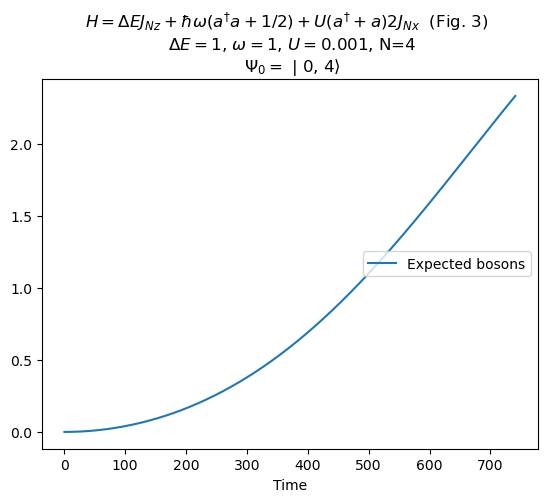

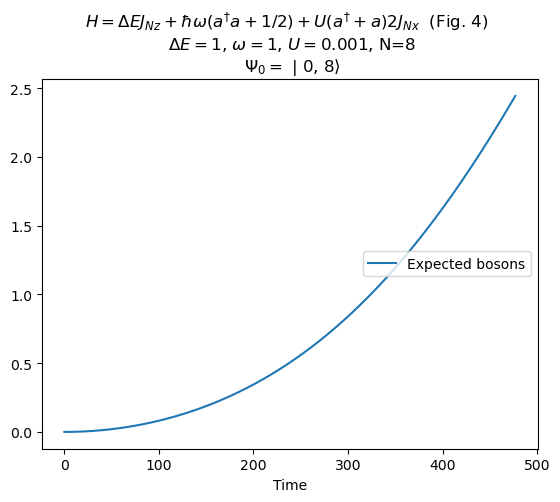

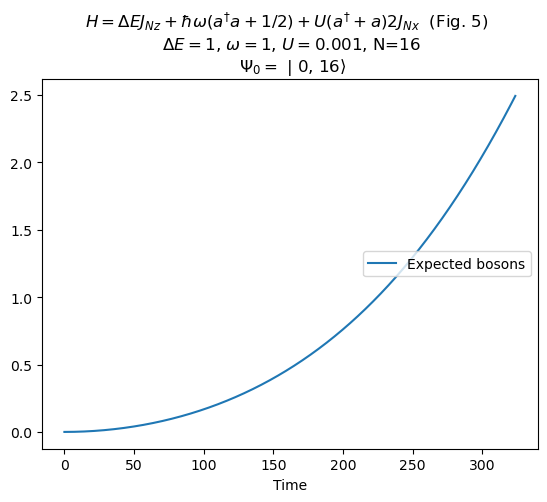

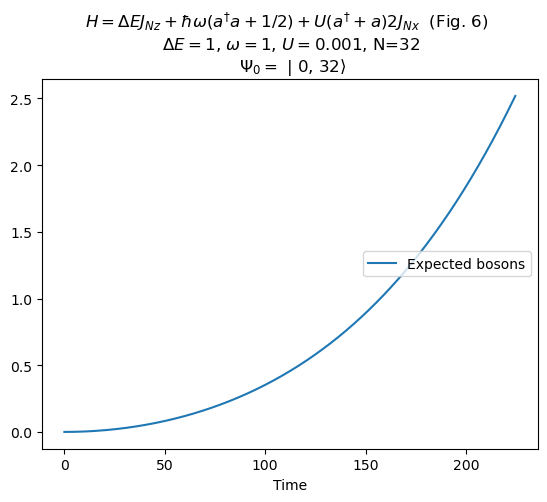

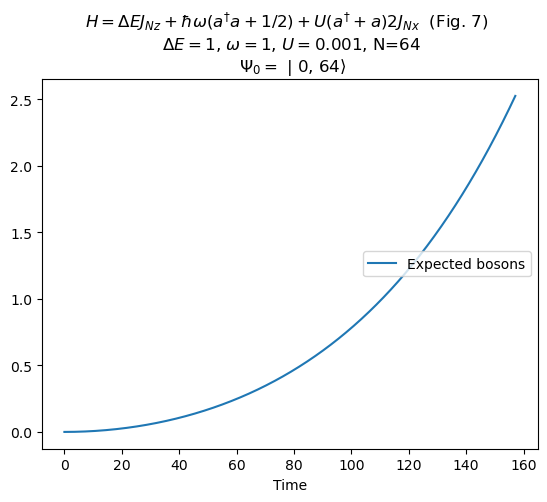

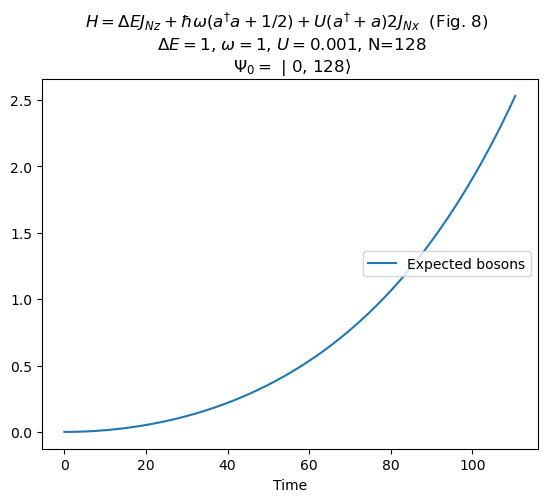

CPU times: user 23.3 s, sys: 2.96 s, total: 26.2 s
Wall time: 18.5 s


In [367]:
%%time 
# %%time must be at the top of the cell and by itself. It tells you the "Wall time" (how long the cell took to run) at the end of the output (should be about 2 min).

Ns = [1,2,4,8,16,32,64,128] # number of TLS we want to simulation
freq = [] # For storing frequency associated with emission of a single boson

# Simulation end time for the first simulation - we'll change this dynamically
tend = 2000.0

for i, N in enumerate(Ns):
    if N==1:
        # For N=1 the parity is opposite to the other N's
        two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=N+1, parity=-1, num_TLS=N)
    else:
        two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=N+1, parity=1, num_TLS=N)

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    H = DeltaE*two_state + omega*bosons + U*interaction

    psi0_ind = nm_list.index((0,N))  # Field in vacuum state (0) with N/2 excitations (int(N/2))
    psi0 = basis(len(nm_list), psi0_ind)

    # Dynamically change the simulation time
    times = np.linspace(0,  tend, 1000)

    # We can use use QuTips sesolve here because of the shorter
    # simulation time. Sometimes sesolve is still fastser than
    # our custom solver because of unknown optimisations made
    # made the QuTip/Numpy teams.
    result = sesolve(H, psi0, times, [number])

    if N==1:
        # N=1 is special because number of bosons never crosses 1 so we need to use find_peaks just like in the last tutorial
        peaks, _ = find_peaks(result.expect[0], prominence=0.05)
        peak_times = times[peaks]
        time_to_emit_one = peak_times[0]
    else: 
        # Approximate time when the expected bosons reaches 1. We look for when expected bosons crosses 1.
        crossing_one_index = np.where(np.diff((result.expect[0] > 1).astype(int)))[0][0]
        time_to_emit_one = times[crossing_one_index]
    
    freq.append(2*np.pi / time_to_emit_one)

    # Update the end of the simulation time for the next simulation. We expect the next simulation 
    # to have shorter emission time than the last, so we can end the next simulation and the
    # time when this simulation emitted its first boson.
    tend = time_to_emit_one

    plt.plot(times, result.expect[0], label="Expected bosons")
    plt.xlabel("Time")
    plt.legend(loc="right")
    plt.title(f"{H_latex} (Fig. {i+1})  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N} \n $\Psi_0 =$ {ket_labels[psi0_ind]}")
    plt.show();

Let's see how the emission rate varies with with number of TLS $N$. 

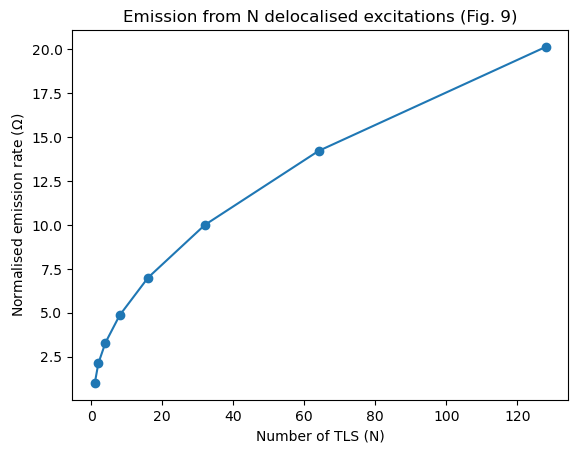

In [368]:
plt.plot(Ns,freq/freq[0],"-o")
plt.xlabel("Number of TLS (N)")
plt.ylabel("Normalised emission rate ($\Omega$)");
plt.title("Emission from N delocalised excitations (Fig. 9)");

Fig. 9 does not look like the linear slope we were expecting at all. Let's see what the relationship is.

In [369]:
print("slope = ", linregress(np.log10(Ns), np.log10(freq)).slope)

slope =  0.5878903337808647


In [370]:
print("rvalue = ", linregress(np.log10(Ns), np.log10(freq)).rvalue)

rvalue =  0.9918318294771615


The scaling of the emission rate is approximately $\sqrt{N}$ - slower than we'd expect based on our intuition. 

Another surprise is waiting for us when we simulate $N$ TLS in which only one is excited.

This time, we'll just output the scaling plot.

In [390]:
from scipy.signal import savgol_filter


In [425]:
second_derivative = savgol_filter(result.expect[0], window_length=51, polyorder=2, deriv=2, delta=(times[1]-times[0]))


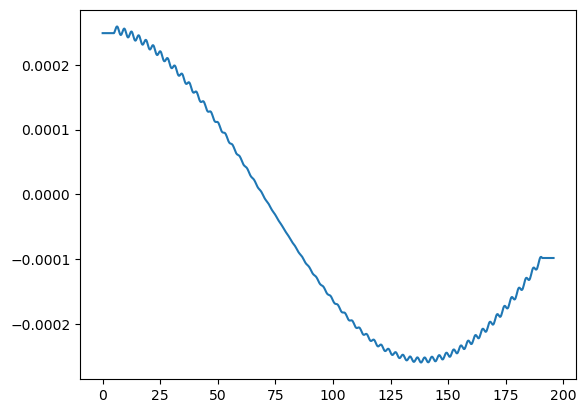

In [426]:
plt.plot(times,second_derivative)

In [427]:
second_derivative[0]

0.0002487955604905589

In [409]:
from scipy.ndimage import gaussian_filter1d


In [423]:
smoothed_data = gaussian_filter1d(result.expect[0], 50)
first_derivative = np.gradient(smoothed_data, (times[1]-times[0]))
second_derivative = np.gradient(first_derivative, (times[1]-times[0]))

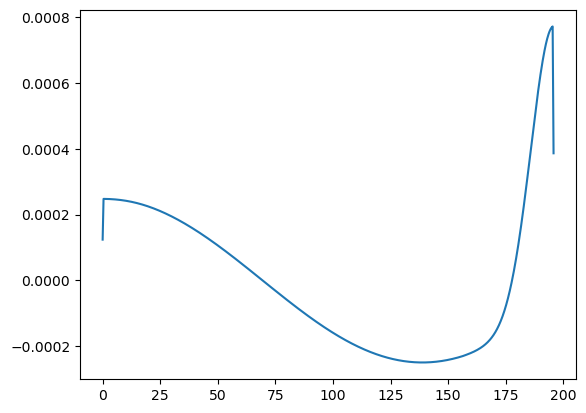

In [424]:
plt.plot(times,second_derivative)

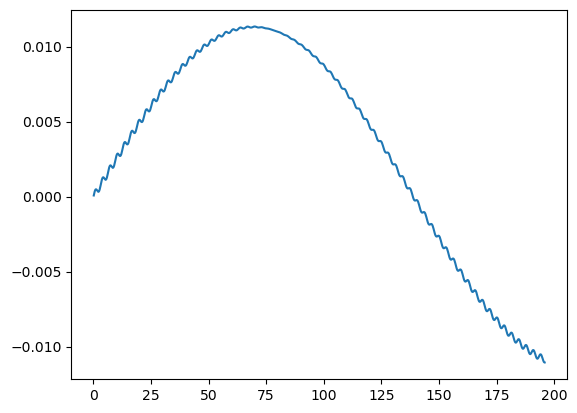

In [389]:
plt.plot(times[1:],np.diff(result.expect[0],1)/(times[1]-times[0]))

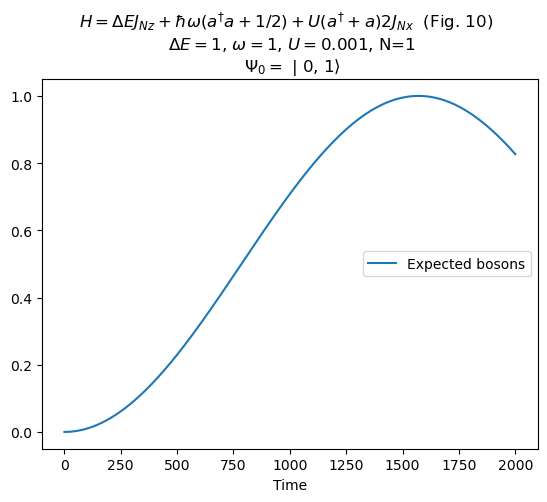

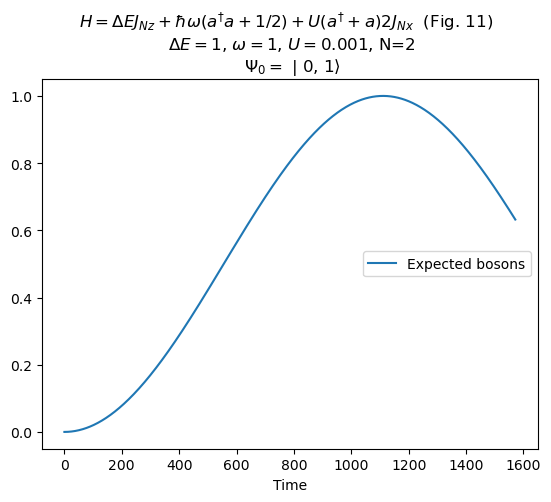

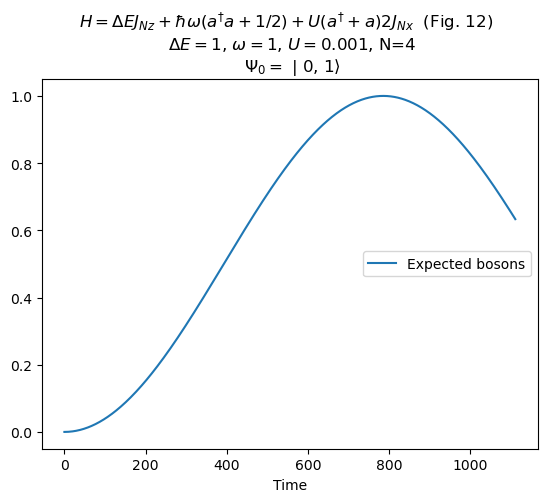

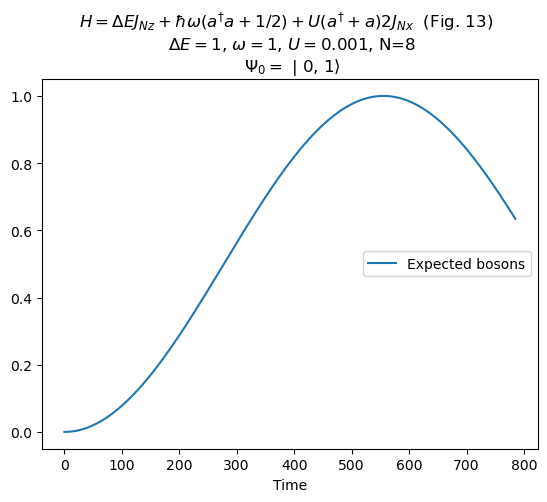

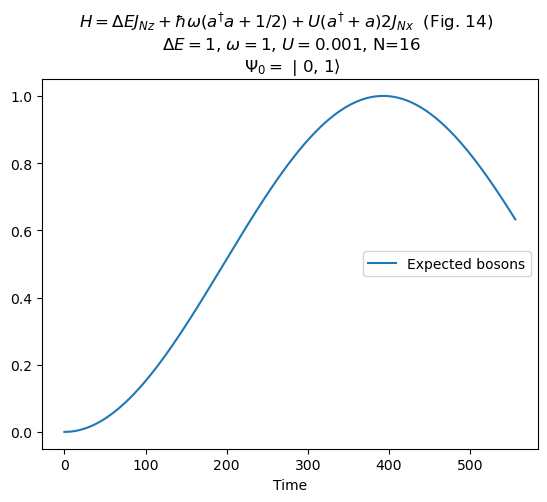

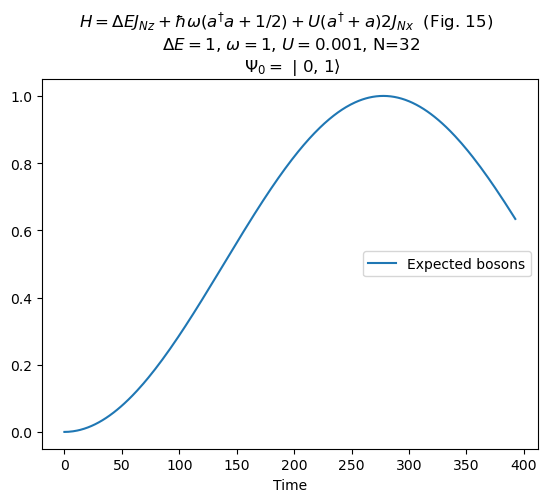

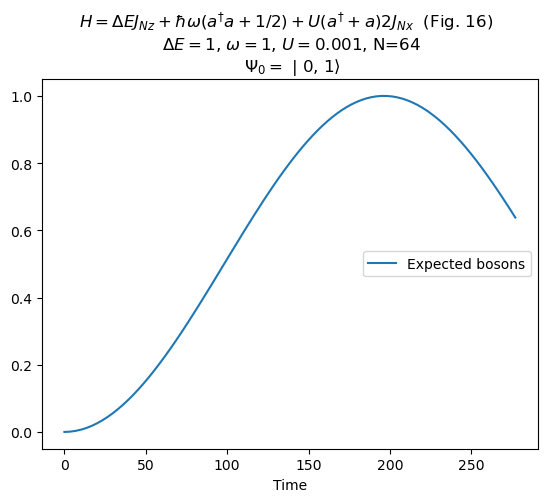

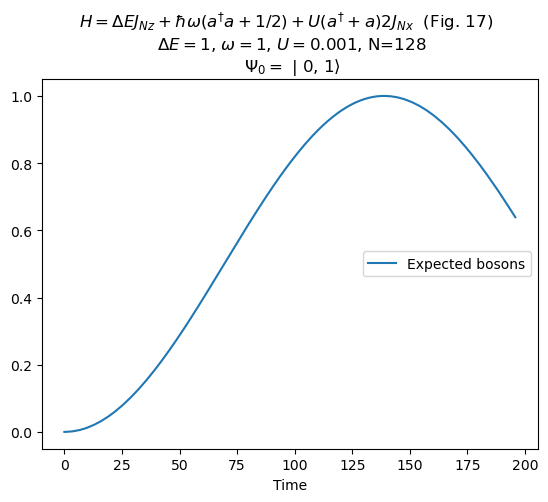

CPU times: user 6.51 s, sys: 2.75 s, total: 9.25 s
Wall time: 1.74 s


In [428]:
%%time 
# %%time must be at the top of the cell and by itself. It tells you the "Wall time" (how long the cell took to run) 
# at the end of the output 

Ns = [1,2,4,8,16,32,64,128] # number of TLS we want to simulation
freq = [] # For storing frequency associated with emission of a single boson
freq2 = []

# Simulation end time for the first simulation - we'll change this dynamically
tend = 2000.0

for i, N in enumerate(Ns):
    two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=2, parity=-1, num_TLS=N)

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    H = DeltaE*two_state + omega*bosons + U*interaction

    psi0_ind = nm_list.index((0,1))  # Field in vacuum state (0) with single excitation (1)
    psi0 = basis(len(nm_list), psi0_ind)

    # Dynamically change the simulation time
    times = np.linspace(0,  tend, 1000)

    # We can use use QuTips sesolve here because of the shorter
    # simulation time. Sometimes sesolve is still fastser than
    # our custom solver because of unknown optimisations made
    # made the QuTip/Numpy teams.
    result = sesolve(H, psi0, times, [number])

    # The number of bosons never crosses 1 in this set of simulation so we need to use 
    # find_peaks just like in the last tutorial
    # The peak_2 - peak_1 should give us the end of the first rabi cycle because we start with zero bosons
    peaks, _ = find_peaks(result.expect[0], prominence=0.05)
    peak_times = times[peaks]
    time_to_emit_one = peak_times[0]
   
    freq.append(2*np.pi / time_to_emit_one)

    second_derivative = savgol_filter(result.expect[0], window_length=51, polyorder=2, deriv=2, delta=(times[1]-times[0]))
    freq2.append(second_derivative[0])

    # Update the end of the simulation time for the next simulation. We expect the next simulation 
    # to have shorter emission time than the last, so we can end the next simulation and the
    # time when this simulation emitted its first boson.
    tend = time_to_emit_one

    plt.plot(times, result.expect[0], label="Expected bosons")
    plt.xlabel("Time")
    plt.legend(loc="right")
    plt.title(f"{H_latex} (Fig. {i+10})  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N} \n $\Psi_0 =$ {ket_labels[psi0_ind]}")
    plt.show();


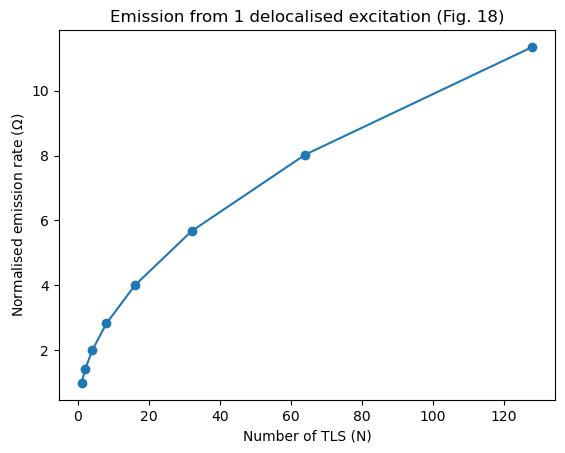

In [378]:
plt.plot(Ns,freq/freq[0],"-o")
plt.xlabel("Number of TLS (N)")
plt.ylabel("Normalised emission rate ($\Omega$)");
plt.title("Emission from 1 delocalised excitation (Fig. 18)");

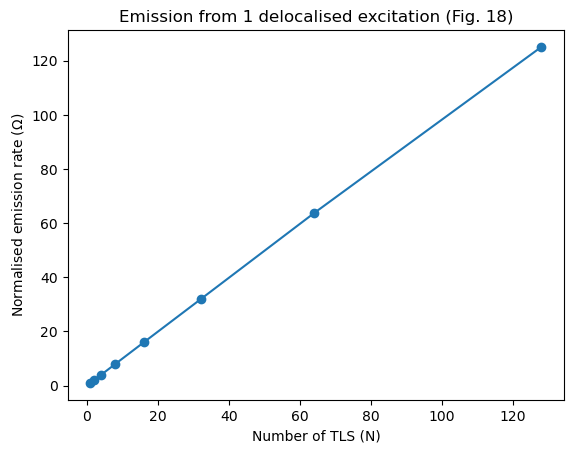

In [429]:
plt.plot(Ns,freq2/freq2[0],"-o")
plt.xlabel("Number of TLS (N)")
plt.ylabel("Normalised emission rate ($\Omega$)");
plt.title("Emission from 1 delocalised excitation (Fig. 18)");

In [374]:
print("slope = ", linregress(np.log10(Ns), np.log10(freq)).slope)

slope =  0.5006468420918875


In [375]:
print("rvalue = ", linregress(np.log10(Ns), np.log10(freq)).rvalue)

rvalue =  0.9999996859940471


Fig. 10 shows the $\sqrt{N}$ scaling that we saw in the previous tutorial (only now we can simulate 100+ TLS). Intuition would tell us that the emission rate should be independent of $N$ because we've only got 1 TLS that is capable of transition in our setup. 

We've got less emission than expected with N excitations and more for a single excitation - what is going on here?

Before we try and simulate superradiance, let's see if we can reproduce our results from last time with the emission of a single boson from a system with many TLS with a single excitation.

You'll notice that the code below is the same as last time, other than the way we create the initial $\Psi_0$ - it's now much simpler `nm_list.index((0,1))` because of our new basis.

We're going to reduce the coupling constant by a factor of 10 compared to the last tutorial because we're now going to try simulating 100+ TLS. The more TLS we have and the larger number of bosons present, the less of a perturbation the field becomes. If we want to stay in a perturbative regime, then $U$ need to be reduced accordingly.

In [194]:
DeltaE = 1
omega = 1
U = 0.001 # Note this is a factor of 10 lower than in the last tutorial

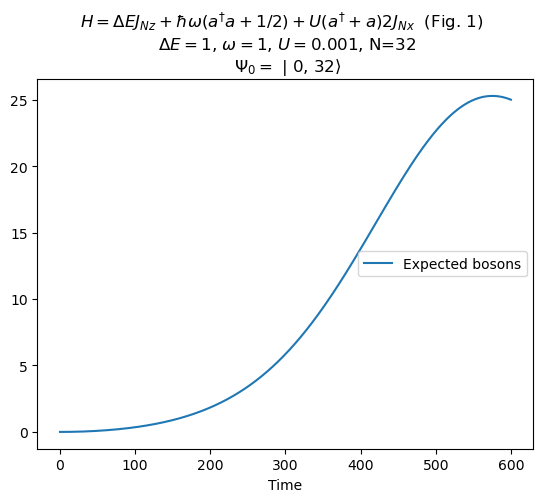

CPU times: user 2.38 s, sys: 244 ms, total: 2.62 s
Wall time: 2.21 s


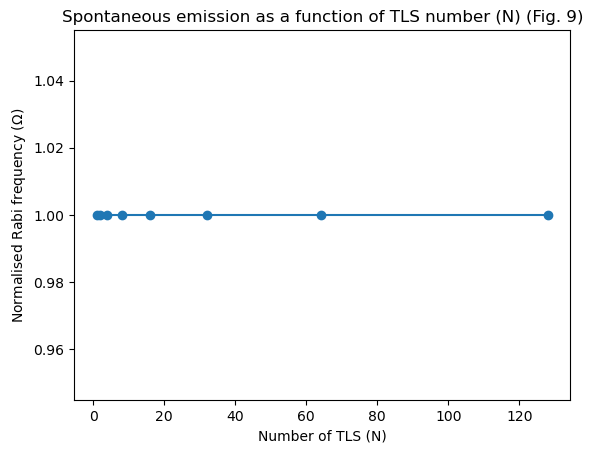

In [196]:
plt.plot(Ns,rabi/rabi[0],"-o")
plt.xlabel("Number of TLS (N)")
plt.ylabel("Normalised Rabi frequency ($\Omega$)");
plt.title("Spontaneous emission as a function of TLS number (N) (Fig. 9)");

In [174]:
print("slope = ", linregress(np.log10(Ns), np.log10(rabi)).slope)

slope =  0.499416810710313


In [175]:
print("rvalue = ", linregress(np.log10(Ns), np.log10(rabi)).rvalue)

rvalue =  0.9999995055831344


Fig. 9 shows that we can not only recover what we discovered in the last tutorial but now we can simulate an order of magnitude more TLS 💪.

Let's see if we can recover Dicke's superradiant $N^2$ enhancement.

First we'll need to set $N$ TLS and $N/2$ excitations. We do this via `psi0_ind = nm_list.index((0,int(N/2)))`  - field in vacuum state (0) with N/2 excitations (int(N/2))

Next, we're going to need to change how we measure emission time. Previously we relied on the Rabi cycle and searching for the peaks in oscillations of the expectation number of bosons. Now, because we've got the potential to have $N/2$ bosons, we're going to need to search for times when the expected number of bosons reaches 1. We can then define a frequency associated with this time just as we did with Rabi frequency.

Finally, we're going to need to dynamically shorten our simulations so that we retain good accuracy in finding when 1 boson is emitted. We need to do this because we expect shorter and shorter emissions times because of the superradiant effects.

In [5]:
DeltaE = 1
omega = 1
U = 0.001 # Note this is a factor of 10 lower than in the last tutorial

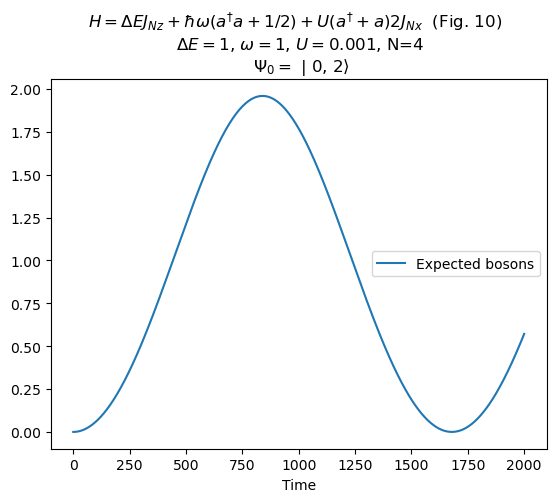

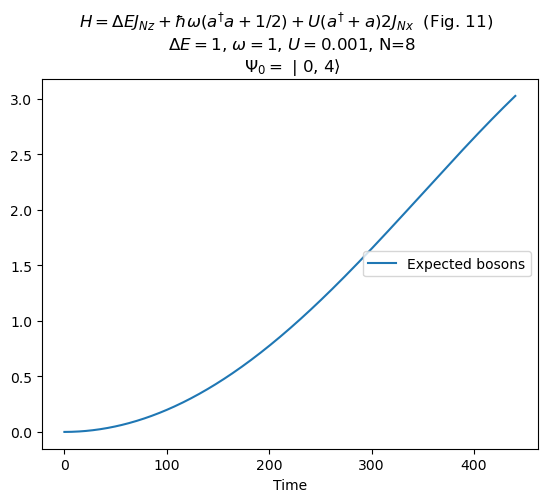

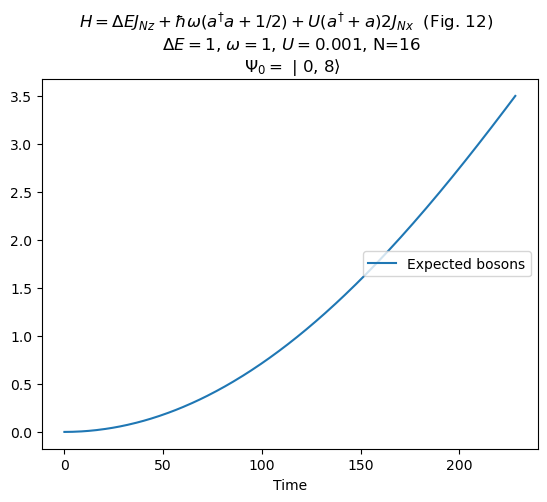

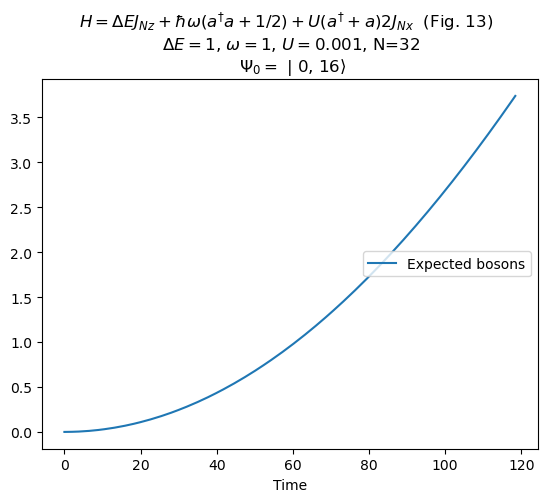

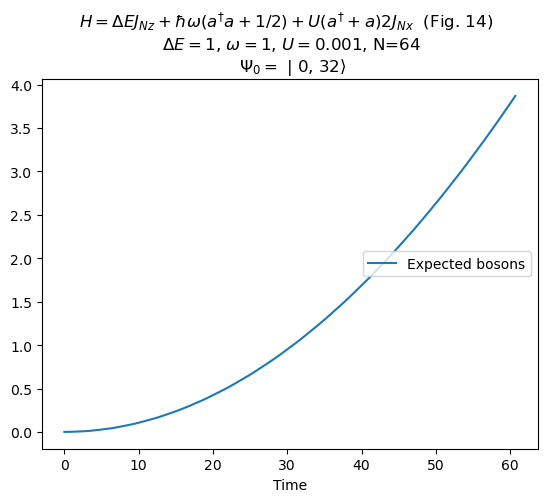

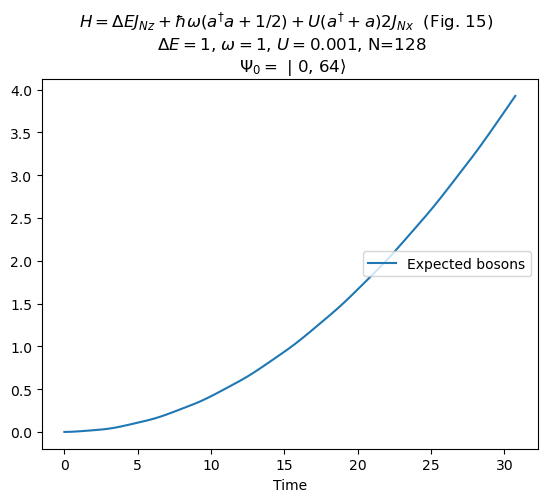

CPU times: user 6.59 s, sys: 1.91 s, total: 8.49 s
Wall time: 2.26 s


In [18]:
%%time 
# %%time must be at the top of the cell and by itself. It tells you the "Wall time" (how long the cell took to run) at the end of the output (should be about 2 min).

Ns = [4,8,16,32,64,128] # number of TLS we want to simulation
freq = [] # For storing frequency associated with emission of a single boson
freq2 = []

# Simulation end time for the first simulation - we'll change this dynamically
tend = 2000.0

for i, N in enumerate(Ns):
    two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=int(N/2)+1, parity=1, num_TLS=N)

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    H = DeltaE*two_state + omega*bosons + U*interaction

    psi0_ind = nm_list.index((0,int(N/2)))  # Field in vacuum state (0) with N/2 excitations (int(N/2))
    psi0 = basis(len(nm_list), psi0_ind)

    # Dynamically change the simulation time
    times = np.linspace(0,  tend, 1000)

    # We can use use QuTips sesolve here because of the shorter
    # simulation time. Sometimes sesolve is still fastser than
    # our custom solver because of unknown optimisations made
    # made the QuTip/Numpy teams.
    result = sesolve(H, psi0, times, [number])

    # Approximate time when the expected bosons reaches 1
    crossing_one_index = np.where(np.diff((result.expect[0] > 1).astype(int)))[0][0]
    time_to_emit_one = times[crossing_one_index]
    
    freq.append(2*np.pi / time_to_emit_one)

    second_derivative = savgol_filter(result.expect[0], window_length=31, polyorder=2, deriv=2, delta=(times[1]-times[0]))
    freq2.append(second_derivative[0])

    # Update the end of the simulation time for the next simulation. We expect the next simulation 
    # to have shorter emission time than the last, so we can end the next simulation and the
    # time when this simulation emitted its first boson.
    tend = time_to_emit_one

    plt.plot(times, result.expect[0], label="Expected bosons")
    plt.xlabel("Time")
    plt.legend(loc="right")
    plt.title(f"{H_latex} (Fig. {i+10})  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N} \n $\Psi_0 =$ {ket_labels[psi0_ind]}")
    plt.show();

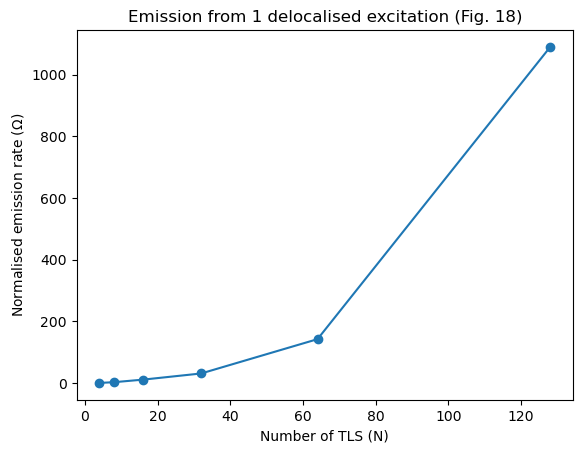

In [20]:
plt.plot(Ns,freq2/freq2[0],"-o")
plt.xlabel("Number of TLS (N)")
plt.ylabel("Normalised emission rate ($\Omega$)");
plt.title("Emission from 1 delocalised excitation (Fig. 18)");

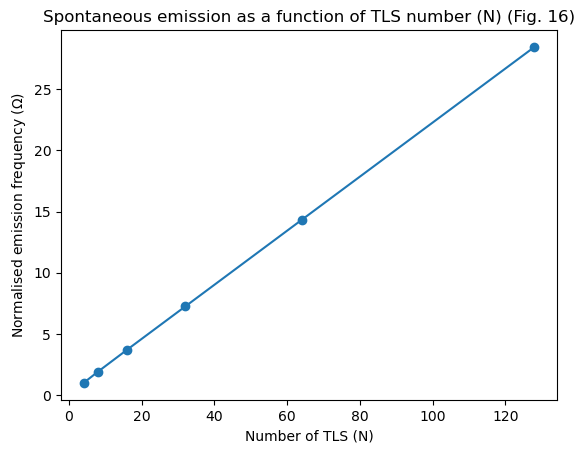

In [11]:
plt.plot(Ns,freq/freq[0],"-o")
plt.xlabel("Number of TLS (N)")
plt.ylabel("Normalised emission frequency ($\Omega$)");
plt.title("Spontaneous emission as a function of TLS number (N) (Fig. 16)");

In [21]:
print("slope = ", linregress(np.log10(Ns), np.log10(freq2)).slope)

slope =  1.9472741723802007


In [180]:
print("slope = ", linregress(np.log10(Ns), np.log10(freq)).slope)

slope =  0.9656400310350665


In [181]:
print("rvalue = ", linregress(np.log10(Ns), np.log10(freq)).rvalue)

rvalue =  0.9999549969557976


How about N excited

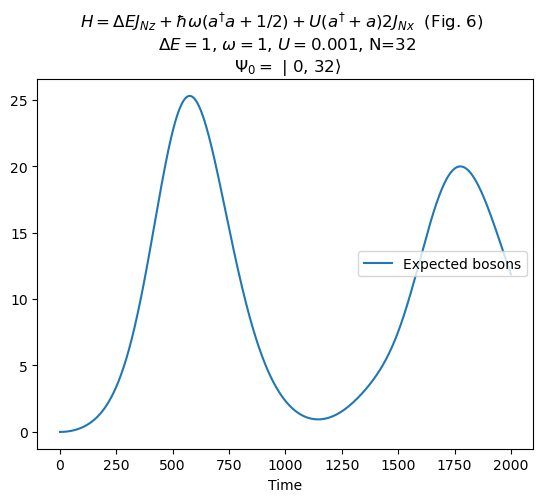

CPU times: user 5.33 s, sys: 542 ms, total: 5.87 s
Wall time: 4.77 s


In [214]:
%%time 
# %%time must be at the top of the cell and by itself. It tells you the "Wall time" (how long the cell took to run) at the end of the output (should be about 2 min).

Ns = [4,8,16,32,64,128] # number of TLS we want to simulation
Ns = [32]
# times = np.linspace(0.0, 1200.0, 1000) # simulation time
rabi = [] # For storing rabi frequency associated with excitation transfer

tend = 2000.0

# opts = Options(nsteps=1000000,atol=1e-10, rtol=1e-6)

for i, N in enumerate(Ns):
    two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=N+1, parity=1, num_TLS=N)

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    H = DeltaE*two_state + omega*bosons + U*interaction

    psi0_ind = nm_list.index((0,N))  # Field in vacuum state (0) with single excitation (1)
    psi0 = basis(len(nm_list), psi0_ind)

    times = np.linspace(0,  tend, 1000)

    # We are using custom simulate and expectation function from last tutorial. These are quicker than QuTips solvers for our specific purpose
    # P, psi = simulate(H, psi0, times)
    # bosons_expectation = expectation(number,psi)

    result = mesolve(H, psi0, times, [], [psi0*psi0.dag(), number])

    time_to_emit_one = times[np.where(np.abs((result.expect[1]-1))<0.01)[0][0]]

    # time_to_emit_one = times[np.where(np.abs((np.array(bosons_expectation)-1))<0.01)[0][0]]
    
    rabi.append(2*np.pi / time_to_emit_one)
    tend = time_to_emit_one

    # # find_peaks from SciPy helps us find peaks.
    # # The peak_2 - peak_1 should give us the end of the first rabi cycle because we start with zero bosons
    # peaks, _ = find_peaks(bosons_expectation, prominence=0.05)
    # peak_times = times[peaks]
   
    # rabi.append(2*np.pi / (peak_times[1] - peak_times[0]))
    # # print((peak_times[1] - peak_times[0]))

    plt.plot(times, result.expect[1], label="Expected bosons")
    plt.xlabel("Time")
    plt.legend(loc="right")
    plt.title(f"{H_latex} (Fig. {i+6})  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N} \n $\Psi_0 =$ {ket_labels[psi0_ind]}")
    plt.show();

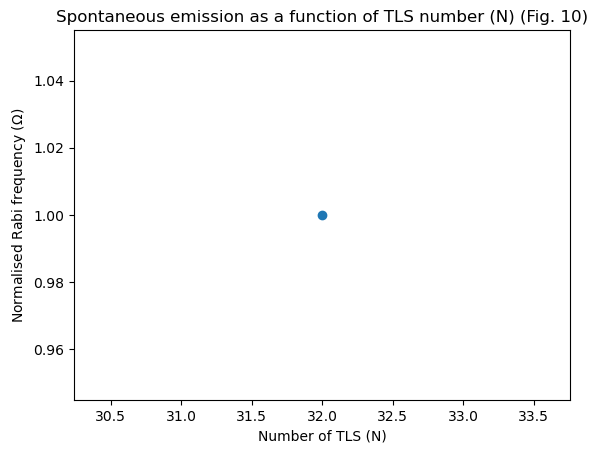

In [207]:
plt.plot(Ns,rabi/rabi[0],"-o")
plt.xlabel("Number of TLS (N)")
plt.ylabel("Normalised Rabi frequency ($\Omega$)");
plt.title("Spontaneous emission as a function of TLS number (N) (Fig. 10)");

In [192]:
print("slope = ", linregress(np.log10(Ns), np.log10(rabi)).slope)

slope =  0.5209285759503954


In [189]:
print("rvalue = ", linregress(np.log10(Ns), np.log10(rabi)).rvalue)

rvalue =  0.999785998757604


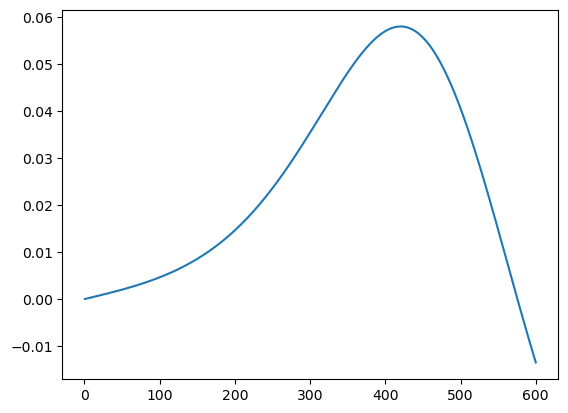

In [213]:
plt.plot(times[1:],np.diff(result.expect[1]))

In [226]:
np.cos([2,4])**2

array([0.17317819, 0.42724998])

In [269]:
rab = np.zeros(len(times))

N=32
for i in range(N,0,-1):
    rab += np.sin(np.sqrt(i*(N-i+1))*times*U*2)**2

# rab = rab**2



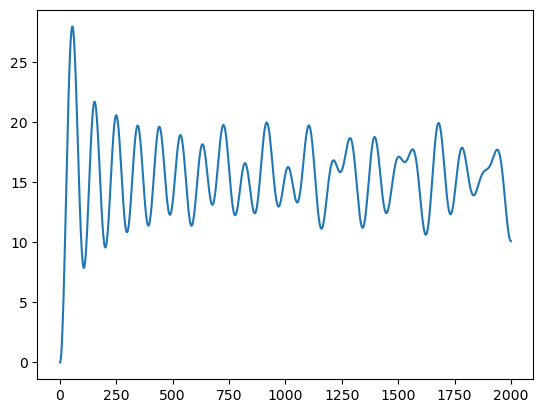

In [270]:
plt.plot(times,rab)

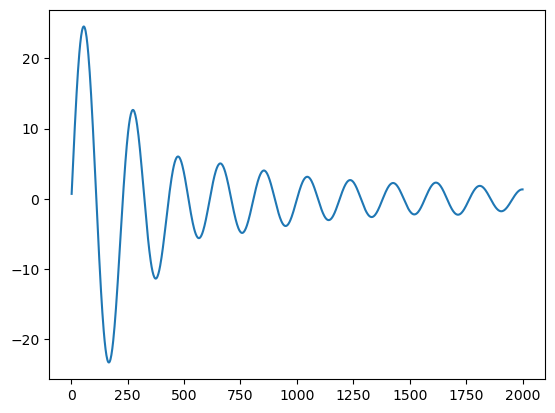

In [260]:
plt.plot(times[1:],np.diff(rab))



higher the Rabi frequency and so 
> Side note: it is worth reiterating that true, irreversible spontaneous emission involves coupling to a continuum of modes. The rates of emission in that case are the square of the rates determined using the Rabi frequency.

As you might imagine, the emission rate also depends on the number of TLS that are excited. We might argue, for example, that the rate of emission is simply the sum of the rates of the individual TLS. In other words, we'd expect a factor of $N$ speedup for $N$ TLS that are excited.

For example, a state like $ | 0, +, +, +, + \rangle $ would be expected to radiate 4 times as fast as $| 0, +\rangle $ because we've got 4 TLS that are excited; that is indeed what happens.

However, Dicke found in 1956 that this is not the whole story. Let's imagine, for example, that we have a single excited TLS amongst 4, but we don't know which specific TLS is excited. One way of representing that state is:

$\Psi_1 = \frac{1}{\sqrt{4}}\left(| 0, +, -, -, - \rangle + | 0, -, +, -, - \rangle + | 0, -, -, +, - \rangle + | 0, -, -, -, + \rangle \right)$

We can describe such states as having an excitation that is "delocalised" across the 4 TLS.

Even though there is only single excitation, the emission rate from $\Psi_1$ is 4 times higher than for $| 0, +\rangle $ just like the case where all 4 TLS are excited. 

Stranger still is the case of 2 excitations amongst 4 TLS, where again we don't know which specific TLS are excited. A similar way of representing that state is:

$\Psi_2 = \frac{1}{\sqrt{6}}\left(| 0, +, +, -, - \rangle + | 0, +, -, +, - \rangle + | 0, +, -, -, + \rangle + | 0, -, +, +, - \rangle + | 0, -, +, -, + \rangle + | 0, -, -, +, + \rangle \right)$

$\Psi_2$ has a 6 fold increase in emission rate compared to $| 0, +\rangle $.

In general, Dicke found that when $n$ excitations are delocaised across $N$ TLS, the emission is enhanced by a factor of

$n\left(N-n+1\right)$

which is largest when half the TLS are excited giving a rate of $\frac{N}{2}\left(\frac{N}{2}+1\right)$. This $N^2$ dependence of the emission has come to be known as "Superradiance".

Superradiance might at first seem counterintuitive, but we can understand it from one of the most fundamental principles of quantum mechanics [according to Richard Feynman](https://www.feynmanlectures.caltech.edu/III_01.html#Ch1-S7) which reads:

```
"When an event can occur in several alternative ways, the probability amplitude for the event is the sum of the probability amplitudes for each way considered separately. There is interference"
```

For the case of 2 excitations amongst 4 TLS, there are 6 starting states that the excitations could be in. Each of the 2 excitations in those 6 states could transition from $+$ to a $-$ with a release ofa a single boson. That means each of the 6 states has 2 paths in which it could go in order to reach one of 4 final states in which there is only a single excitation. The total number of paths is therefore $6\times 2 = 12$. Each of these paths contributes the same to the overall amplitude because the Dicke state is constructed with $+$ between each bit of the state. This creates what we call constructive interference where the effects of each path add up to a larger effect. What we have to remember to get the number right is that our states are normalised. The 6 options for our starting state means we must divide by $\sqrt{6}$. The 4 options for the final state means dividing by $\sqrt{4}$. So the amplitude enhancement factor is:

$$\frac{6\times 2}{\sqrt{6}\sqrt{4}} = \sqrt{6}$$

and because emission rates are related to probabilities which are the given by the square of the amplitude then we get the factor of 6 which at first seemed so surprising.

The general Dicke formula for the rate enhancement comes from doing this counting and normalising for the general case:

$$\left(\frac{^N C_n n}{\sqrt{^N C_n}\sqrt{^N C_{n-1}}}\right)^2 = n\left(N-n+1\right)$$

We can see just how important those $+$'s are that make up the Dicke state. As soon as you allow any $-$ you reduce the emission rates. Take for example the case of 2 TLS with a single delocalised excitation. If instead of a Dicke state

$\Psi = \frac{1}{\sqrt{2}}\left(| 0, +, -\rangle + | 0, -, + \rangle \right)$

we instead use 

$\Psi = \frac{1}{\sqrt{2}}\left(| 0, +, -\rangle - | 0, -, + \rangle \right)$

then we get no emission at all because we get complete destructive interference of the two paths. Such states are often referred to as "dark states"

It's worth recalling that in classical physics we have similar enhancements of scattering intensities when scattering is done coherently. In this situation the scatterers are all acting in sync, contributing to the same wave with same phase that's not randomly changing in time. That's what creates light and dark fringes in things like youngs slits. It's the origin of the refractive index. The scaling of the intensity goes as the sqaure of the number of scatterers whereas incoherent scattering goes as the number of scatteres.
